In [1]:
# preambule
import numpy as np
import os
from sys import path as syspath
syspath.append("../functions/")
import pickle
from itertools import product

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


bases = 'acgt'
lett_to_index = dict(zip(bases,range(4)))

dataset = {
    'Pr' :'NG-9349_LamPr12_mutlibrary_lib118631_4582_1',
    'Pl' :'NG-9350_LamPl12_mutlibrary_lib118630_4582_1',
}
def mode(l):
    from collections import Counter
    return Counter(l).most_common(1)[0][0]

from general_functions import tally
from collections import OrderedDict
import pandas as pd

In [2]:
# import 
mutDict = {}
for dataID in dataset:
    with open("raw/%s/%s_%s_restricted.dmp"%(dataset[dataID],dataset[dataID],dataID),"rb") as f:
        mutDict[dataID] = pickle.load(f)

# filter by sequence length

Text(0.5, 0, 'sequence length')

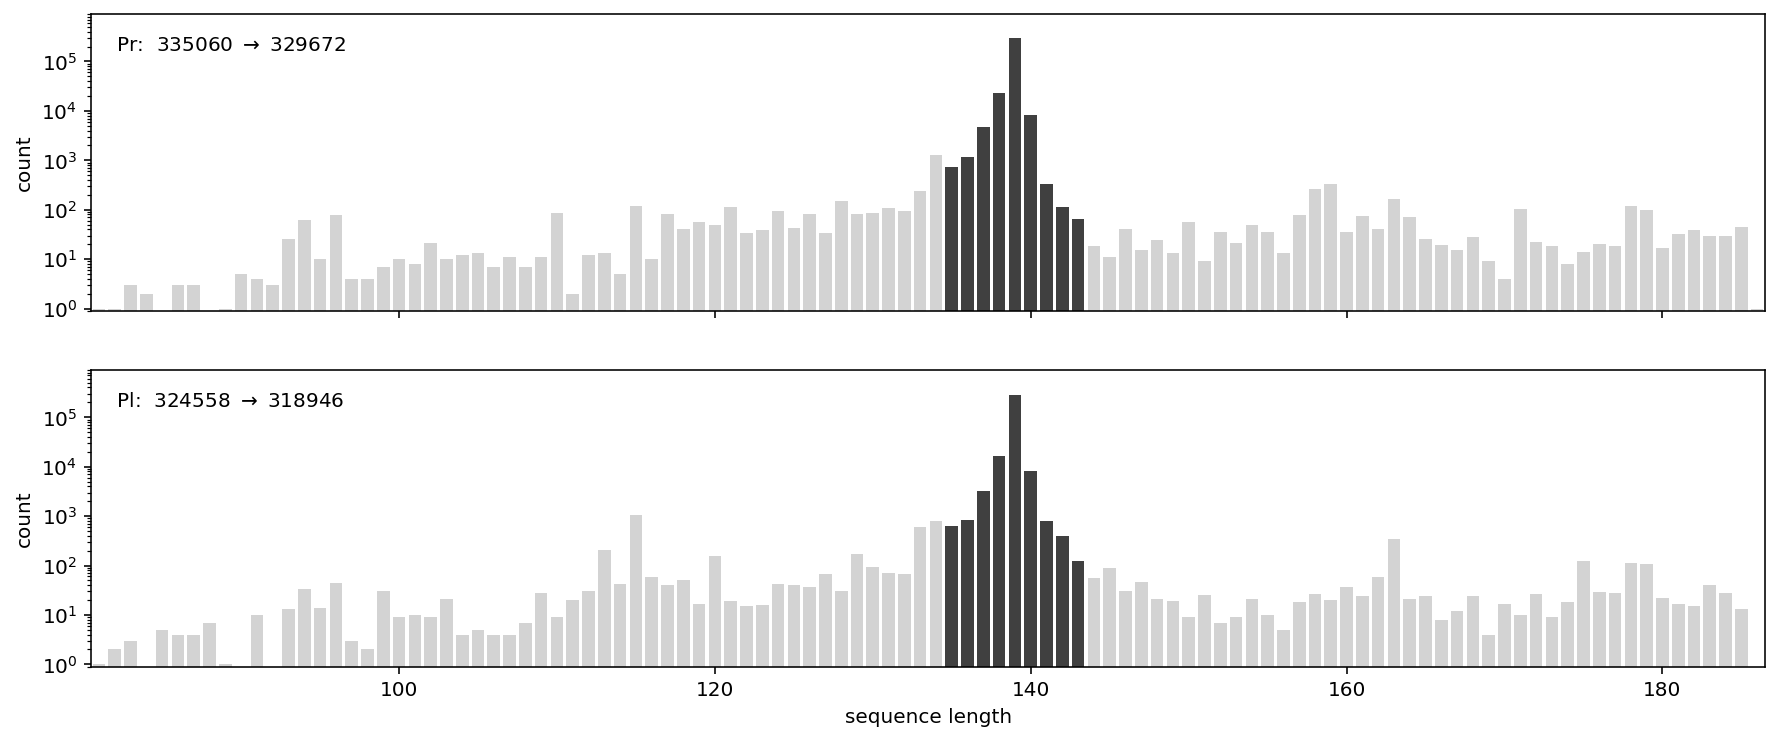

In [3]:
Ltoll = 5
fig, axs = plt.subplots(len(mutDict),1,figsize=(15,3*len(mutDict)), sharex=True, sharey=True)
for ja,dataID in enumerate(dataset):
    Ls0,counts0 = np.array(tally(map(len,mutDict[dataID].keys()))).T
    ax = axs.flat[ja]
    ax.bar(Ls0,counts0, color = 'lightgrey')
    ax.set_yscale("log")
    ax.set_ylabel("count")

    Lpeak = Ls0[np.argmax(counts0)]
    origNseqs = len(mutDict[dataID])
    # removing sequences outside of the tollerance
    ss = list(mutDict[dataID].keys())
    for s in ss:
        if not (Lpeak-Ltoll < len(s) < Lpeak+Ltoll):
            del mutDict[dataID][s]
    Ls,counts = np.array(tally(map(len,mutDict[dataID].keys()))).T
    ax.bar(Ls,counts, color = plt.cm.Greys(.8))
    ax.text(0,1,"\n    "+dataID+r":  %i $\rightarrow$ %i"%(counts0.sum(), counts.sum()), transform = ax.transAxes, va="top")
    ax.set_ylim(.9,9e5)
    ax.set_xlim(80.5,186.5)
ax.set_xlabel("sequence length")

# filter by coverage

In [5]:
seqDF = OrderedDict([(dataID,pd.DataFrame(columns=["Sequence","Measurements_0","Measurements_1","Coverage"]))\
                     for dataID in dataset])

In [13]:
for dataID in dataset:
    seqDF[dataID]["Sequence"] = mutDict[dataID].keys()
    seqDF[dataID]["Measurements_0"] = [mutDict[dataID][s][0] for s in mutDict[dataID].keys()]
    seqDF[dataID]["Measurements_1"] = [mutDict[dataID][s][1] for s in mutDict[dataID].keys()]
    seqDF[dataID]["Coverage"] = list(map(len,seqDF[dataID]["Measurements_1"]))

In [17]:
coverageThreshold = 10

In [18]:
# for dataID in DIDs:
#     ks = mutDictFiltered[dataID].keys()
#     for s in ks:
#         if mutDictFiltered[dataID][s].shape[1]<coverageTheshold:
#             del mutDictFiltered[dataID][s]

(1, 422430.80564616335)

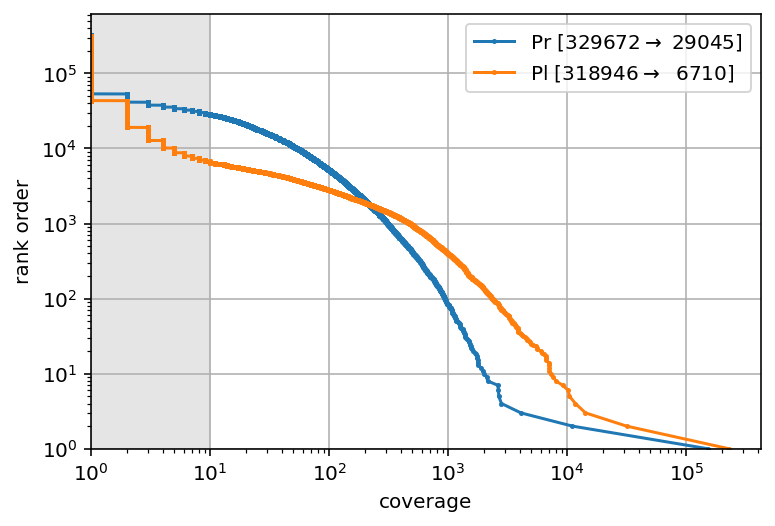

In [19]:
for dataID in dataset:
#     coverage = np.array(map(lambda xi: len(xi[0]),mutDict[dataID].values()))
    x = seqDF[dataID].Coverage.values
    plt.plot(sorted(x), 1+np.arange(len(x))[::-1],
             ".-", ms=3,
             label = r"%s [%i$ \rightarrow$%6i]"%(dataID, len(x), np.sum(x>=coverageThreshold)) )
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel("coverage")
plt.ylabel("rank order")
yl = plt.ylim()
plt.fill_betweenx([-1,1e6],[coverageThreshold]*2, color="grey", alpha = .2)
plt.ylim(1,yl[1])
plt.xlim(1,)

In [21]:
for dataID in dataset:
    seqDF[dataID] = seqDF[dataID].query("Coverage>=%i"%coverageThreshold)

# Mutation rates
conditioned on consensus length and that Shine-Dalgarno is in the right spot

Text(0, 0.5, 'count')

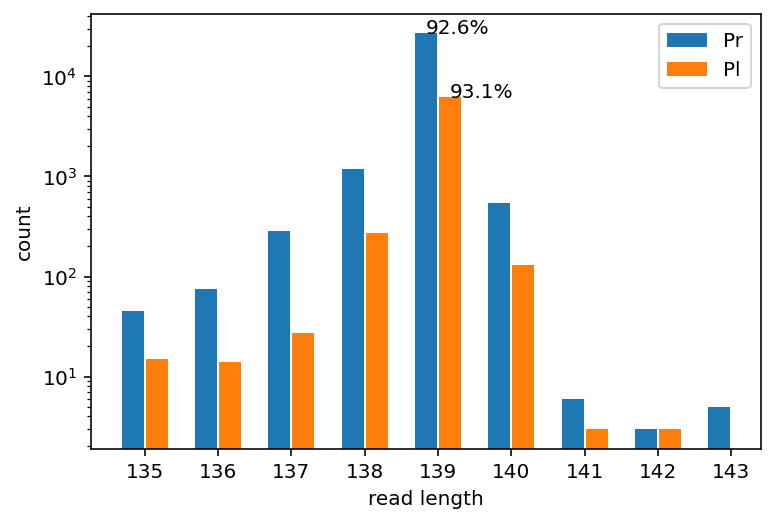

In [22]:
i = -.5
for dataID in dataset:
    Ls,counts = np.array(tally(map(len,seqDF[dataID].Sequence))).T
    dL = i*.33
    plt.bar(Ls+dL,counts, label = r"%s"%(dataID),width=.3, )
    plt.text(Lpeak+dL,counts.max(),"%.1f%%"%(counts.max()/counts.sum()*100))
    i += 1
#     break
plt.yscale("log")
plt.legend()
plt.xticks(range(Lpeak-Ltoll+1,Lpeak+Ltoll))
plt.xlabel("read length")
plt.ylabel("count")

## realign all sequences wrt Shine-Dalgarno

In [23]:
from sequence_functions import aln
from sequence_functions import compare_to

In [24]:
# stackoverflow
def findall(p, s):
    '''Yields all the positions of
    the pattern p in the string s.'''
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)

In [26]:
# only to define ancestor
SA = {dataID: np.array([
    list(row.Sequence) for ix,row in seqDF[dataID].iterrows() \
        if len(row.Sequence)==Lpeak
    ]) for dataID in dataset}
ancestor = {dataID:"".join(map(mode,SA[dataID].T)) for dataID in SA}
del SA

In [28]:
anchorSeq = "agaggag"
consensusAnchor = list(findall(anchorSeq,ancestor["Pr"]))
if len(consensusAnchor)!=1:
    raise ValueError("Nope, anchor sequence is ambiguous")
consensusAnchor = consensusAnchor[0]


assert all([ancestor[dataID].find(anchorSeq)==consensusAnchor for dataID in dataset])

In [29]:
anchorToll = 5

In [30]:
%%time
n_kicked_out = {}
for dataID in dataset:
    n_kicked_out[dataID] = 0
    alignedSeqs = []
    SDpos = []
    for s in seqDF[dataID].Sequence:
        candPos = list(findall(anchorSeq,s))
        if len(candPos)==1:
            candPos = candPos[0]
        elif len(candPos)==0:
            s1,s2,_,begin, end = aln(anchorSeq, s)
            s1 = s1[begin:end]
            s2 = s2[begin:end]
            if (s1+s2).count("-")>0:
                raise ValueError("Exception! need to reimplement this")
            candPos = begin
        else:
            ibest = np.argmin(np.abs(np.array(candPos)-consensusAnchor))
            print ("out of", candPos, "I choose ", candPos[ibest])
            candPos = candPos[ibest]
        SDpos += [candPos]
        if np.abs(candPos-consensusAnchor)>anchorToll:
            alignedSeqs += [""]
            n_kicked_out[dataID] += 1
            continue
        # aligning the sequence
        ss = "a"*anchorToll + s + "a"*anchorToll
        ss = ss[candPos-consensusAnchor+anchorToll:]
        ss = ss[:Lpeak]
        assert len(ss)==Lpeak
        alignedSeqs += [ss]
    seqDF[dataID]["AlignedSeq"] = alignedSeqs
    seqDF[dataID]["Shine-Dalgarno pos"] = SDpos

out of [63, 100] I choose  100
out of [100, 122] I choose  100
out of [79, 100] I choose  100
out of [63, 100] I choose  100
out of [100, 122] I choose  100
out of [79, 100] I choose  100
CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 243 ms


In [31]:
n_kicked_out

{'Pr': 14, 'Pl': 16}

## before filter

In [32]:
from scipy.stats import distributions as dst

In [33]:
SA = {dataID: np.array([
    list(row.Sequence) for ix,row in seqDF[dataID].iterrows() \
        if len(row.Sequence)==Lpeak and row["Shine-Dalgarno pos"]==consensusAnchor
    ]) for dataID in dataset}

CPU times: user 1.31 s, sys: 0 ns, total: 1.31 s
Wall time: 1.32 s


Text(0, 0.5, 'mutation rate, $\\mu$')

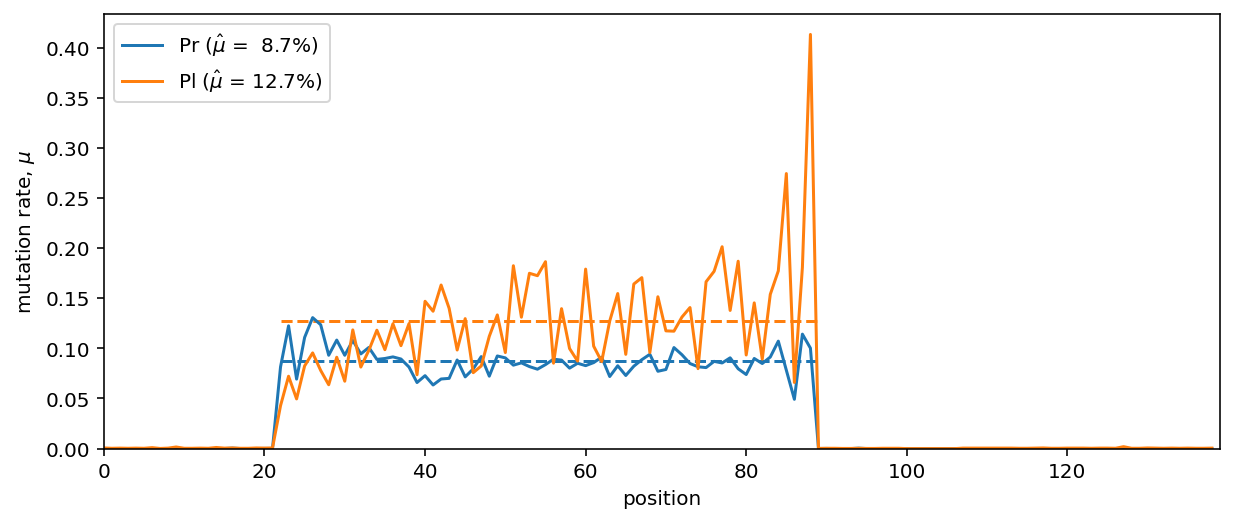

In [34]:
%%time
noMutantsPerPos = {}
mutRatePerPos = {}
plt.figure(figsize=(10,4))
for dataID in SA:
    noMutantsPerPos[dataID] = np.array([np.sum(v!=mode(v)) for v in SA[dataID].T])
    mutRatePerPos  [dataID] = noMutantsPerPos[dataID]*1./len(SA[dataID])
    i0, ie = np.where(np.diff((mutRatePerPos[dataID]>1e-2)))[0]+1
    avgMutRate = mutRatePerPos[dataID][i0:ie].mean()
    c = plt.plot([])[0].get_color()
#     plt.bar(range(len(mutRatePerPos[dataID])),mutRatePerPos[dataID],color=c,
#              label=r"%s ($\hat\mu$ = %4.1f%%)"%(dataID,avgMutRate*100),
#            alpha = .3)
    plt.plot(mutRatePerPos[dataID],c=c,
             label=r"%s ($\hat\mu$ = %4.1f%%)"%(dataID,avgMutRate*100))
    plt.hlines([avgMutRate],[i0],[ie],color=c, linestyle="--")
    
plt.legend(loc=2)
plt.xlim(0,Lpeak)
plt.ylim(0,)
# plt.title("mutation rate per position")
plt.xlabel("position")
plt.ylabel(r"mutation rate, $\mu$")

In [35]:
NmutThreshold = 20

Text(0, 0.5, 'PDF')

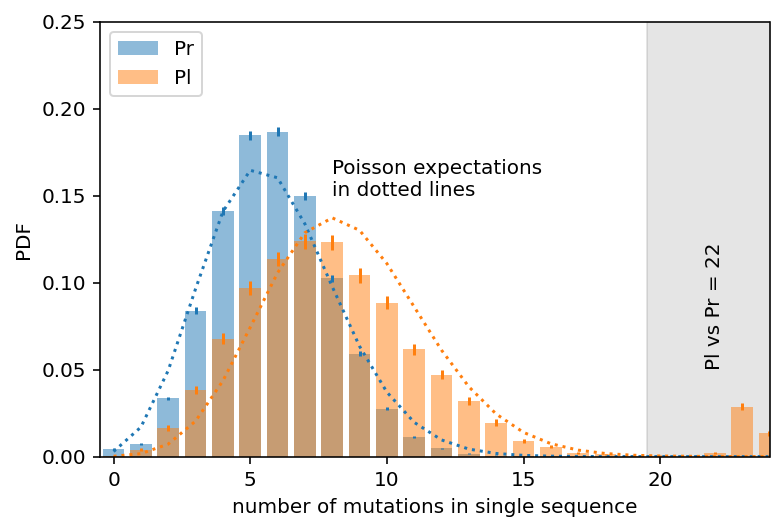

In [36]:
ancArray = {dataID:np.array(list(ancestor[dataID][i0:ie])) for dataID in ancestor}
for dataID in ancestor:
    mutNumber = np.array([(s[i0:ie]!=ancArray[dataID]).sum() for s in SA[dataID]])
    x,y = np.array(tally(mutNumber)).T
    ye = y**.5/y.sum()
    y = y/y.sum()
#     c = plt.plot(x[x<20],y[x<20], label = dataID, lw=.6)[0].get_color()
    c = plt.plot([])[0].get_color()
    plt.bar(x,y, label = dataID, alpha = .5,color=c)
    plt.errorbar(x,y,ye,color=c,ls="none")
    avgmu = mutRatePerPos[dataID][i0:ie].mean()
    yp = dst.poisson.pmf(x,avgmu*(ie-i0))
    plt.plot(x,yp,c=c,ls="dotted",)
#              label="Poisson with $\hat\mu = %.3f$"%avgmu)
plt.fill_betweenx([-1,2], [NmutThreshold-.5]*2,[50]*2, color="grey", alpha = .2)
plt.text(22,.05,"Pl vs Pr = 22", rotation = 90, va="bottom", ha="center")
plt.text(8,.15,"Poisson expectations\nin dotted lines")
plt.legend(loc=2)
plt.xlim(-.5,24)
plt.ylim(0,.25)
plt.xlabel("number of mutations in single sequence")
plt.ylabel("PDF")

## filter on number of mutations and reasonable Shine-Delgarno position

In [26]:
for dataID in DIDs:
    mutNumber = np.array([(s[i0:ie]!=ancArray[dataID]).sum() for s in SA[dataID]])

    tooMutagenized = ["".join(s) for s in SA[dataID][mutNumber>=NmutThreshold]]

    toRemove = np.any([
        seqDF[dataID].Sequence.isin(tooMutagenized),
        seqDF[dataID].AlignedSeq==""
    ], axis=0)

    print (dataID, "%5i -> %5i"%(len(seqDF[dataID]), sum(~toRemove)))
    seqDF[dataID] = seqDF[dataID][~toRemove]

Pr 29045 -> 29020
Pl  6710 ->  6415


In [38]:
for dataID in dataset:
    mutNumber = np.array([(s[i0:ie]!=ancArray[dataID]).sum() for s in SA[dataID]])

    tooMutagenized = ["".join(s) for s in SA[dataID][mutNumber>=NmutThreshold]]

    toRemove = np.any([
        seqDF[dataID].Sequence.isin(tooMutagenized),
        seqDF[dataID].AlignedSeq==""
    ], axis=0)

    print (dataID, "%5i -> %5i"%(len(seqDF[dataID]), sum(~toRemove)))
    seqDF[dataID] = seqDF[dataID][~toRemove]

Pr 29045 -> 29020
Pl  6710 ->  6415


## after filter

In [40]:
SA = {dataID: np.array([
    list(row["AlignedSeq"]) for ix,row in seqDF[dataID].iterrows() \
        if len(row.Sequence)==Lpeak and row["Shine-Dalgarno pos"]==consensusAnchor
    ]) for dataID in dataset}

CPU times: user 1.32 s, sys: 3.69 ms, total: 1.32 s
Wall time: 1.32 s


Text(0, 0.5, 'mutation rate, $\\mu$')

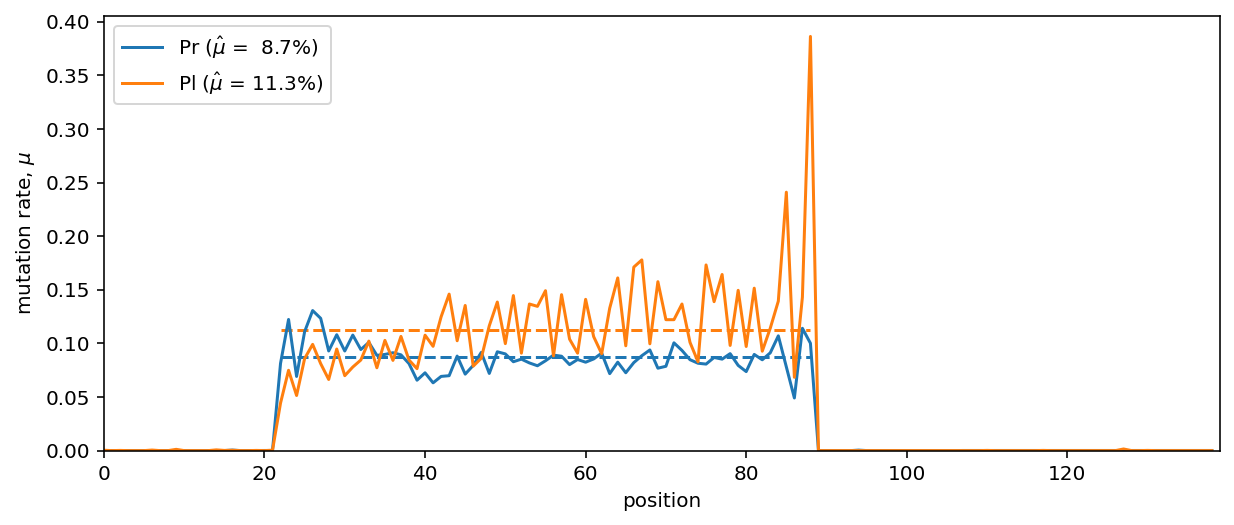

In [41]:
%%time
noMutantsPerPos = {}
mutRatePerPos = {}
plt.figure(figsize=(10,4))
for dataID in SA:
    noMutantsPerPos[dataID] = np.array([np.sum(v!=mode(v)) for v in SA[dataID].T])
    mutRatePerPos  [dataID] = noMutantsPerPos[dataID]*1./len(SA[dataID])
    i0, ie = np.where(mutRatePerPos[dataID]>1e-2)[0][[0,-1]]
    avgMutRate = mutRatePerPos[dataID][i0:ie].mean()
    c = plt.plot([])[0].get_color()
#     plt.bar(range(len(mutRatePerPos[dataID])),mutRatePerPos[dataID],color=c,
#              label=r"%s ($\hat\mu$ = %4.1f%%)"%(dataID,avgMutRate*100),
#            alpha = .3)
    plt.plot(mutRatePerPos[dataID],c=c,
             label=r"%s ($\hat\mu$ = %4.1f%%)"%(dataID,avgMutRate*100))
    plt.hlines([avgMutRate],[i0],[ie],color=c, linestyle="--")
    
plt.legend(loc=2)
plt.xlim(0,Lpeak)
plt.ylim(0,)
# plt.title("mutation rate per position")
plt.xlabel("position")
plt.ylabel(r"mutation rate, $\mu$")

In [42]:
ancestor = {dataID:"".join(map(mode,SA[dataID].T)) for dataID in SA}

Text(0, 0.5, 'PDF')

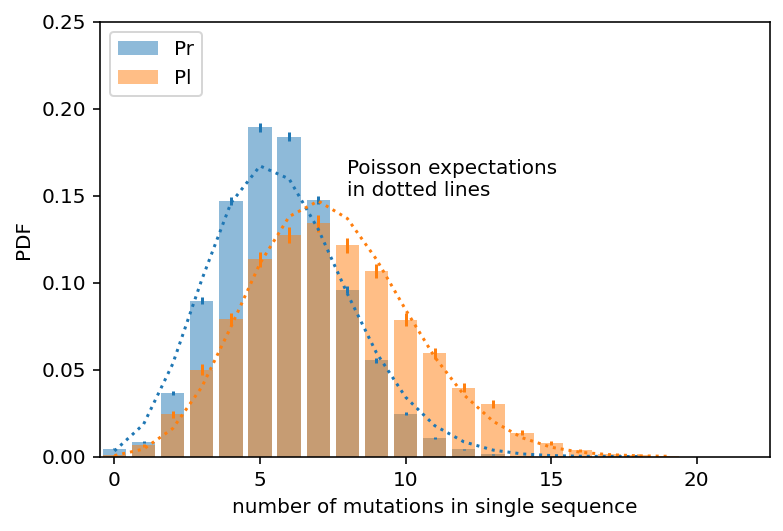

In [43]:
ancArray = {dataID:np.array(list(ancestor[dataID][i0:ie])) for dataID in ancestor}
for dataID in ancestor:
    mutNumber = np.array([(s[i0:ie]!=ancArray[dataID]).sum() for s in SA[dataID]])
    x,y = np.array(tally(mutNumber)).T
    ye = y**.5/y.sum()
    y = y/y.sum()
#     c = plt.plot(x[x<20],y[x<20], label = dataID, lw=.6)[0].get_color()
    c = plt.plot([])[0].get_color()
    plt.bar(x,y, label = dataID, alpha = .5,color=c)
    plt.errorbar(x,y,ye,color=c,ls="none")
    avgmu = mutRatePerPos[dataID][i0:ie].mean()
    yp = dst.poisson.pmf(x,avgmu*(ie-i0))
    plt.plot(x,yp,c=c,ls="dotted",)
#              label="Poisson with $\hat\mu = %.3f$"%avgmu)

plt.text(8,.15,"Poisson expectations\nin dotted lines")
plt.legend(loc=2)
plt.xlim(-.5,22.5)
plt.ylim(0,.25)
plt.xlabel("number of mutations in single sequence")
plt.ylabel("PDF")

# Sequences, means, modes, stds...

In [49]:
for dataID in dataset:
    for act in [0,1]:
        df = seqDF[dataID]
        df["Median_%i"%act] = list(map(np.median,df["Measurements_%i"%act]))
        df["Mode_%i"%act  ] = list(map(     mode,df["Measurements_%i"%act]))
        df["Mean_%i"%act  ] = list(map(  np.mean,df["Measurements_%i"%act]))
        df["Std_%i"%act   ] = list(map(   np.std,df["Measurements_%i"%act]))

In [50]:
statCols = seqDF[dataID].columns[-8:]

In [51]:
from copy import deepcopy

In [52]:
seqStats = {}
for dataID in dataset:
    seqStats[dataID] = []
    for act in [0,1]:
        df = deepcopy(seqDF[dataID][[c for c in statCols if c.endswith(str(act))]])
        df = df.rename({c:c[:-2] for c in statCols}, axis = "columns")
        seqStats[dataID] += [df]

<ipython-input-53-b2ea2f623692>:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(levels, [])
<ipython-input-53-b2ea2f623692>:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(levels, [])


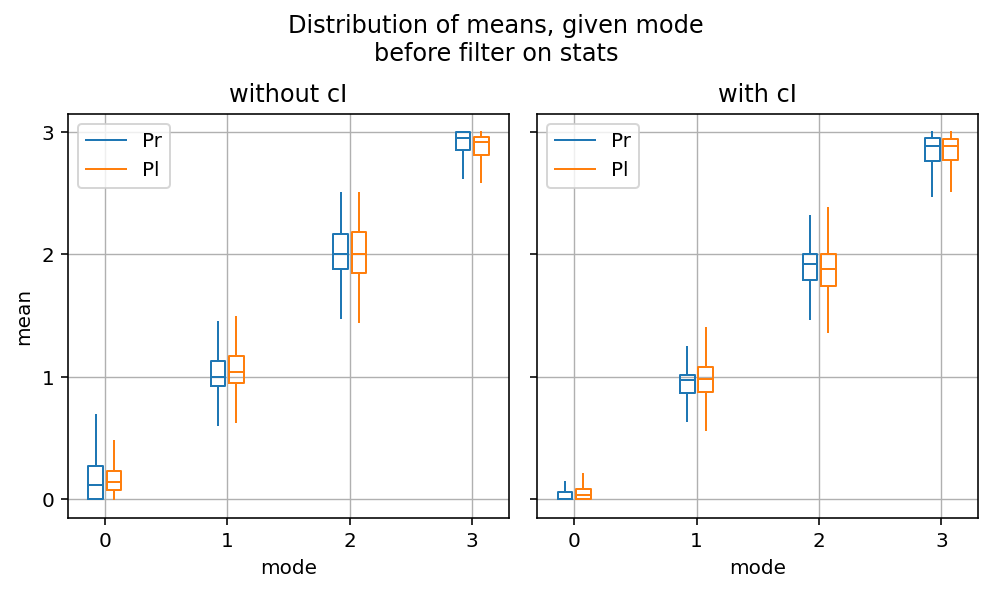

In [53]:
fig, axs = plt.subplots(1,2,figsize=(7,4), sharex=True, sharey=True)
fig.suptitle("Distribution of means, given mode\nbefore filter on stats\n")
for act in [0,1]:
    ax = axs.flat[act]
    ax.grid(lw = .7)
    bx = {}
    for j,dataID in enumerate(dataset):
        df = seqStats[dataID][act]
        levels = sorted(df.Mean.round().astype(int).unique())
        bx[dataID] = ax.boxplot([df.query("Mode==%i"%i)["Mean"] for i in levels],
                    positions=np.arange(4)+.15*(j-.5),
                    boxprops = {"color":"C%i"%j},
                    whiskerprops = {"color":"C%i"%j},
#                     flierprops = {"marker":".",'markerfacecolor':"C%i"%j, "mew":0,"markersize":3},
                    showfliers = False,
                    medianprops = {"color":"C%i"%j},
                    showcaps = False,
                    widths = .12);
    ax.set_xticks(levels, [])
    ax.set_title('without '[:-act*3-1]+" cI")
    ax.set_xlim(-.3,3.3)
    ax.legend([bx[dataID]["boxes"][0] for dataID in bx.keys()],
               bx.keys(), loc=2)
    
    ax.set_xlabel("mode")
    ax.set_xticks(levels)
    ax.set_xticklabels(levels)
    ax.set_aspect("equal")
ax.set_yticks(levels)
ax.set_yticklabels(levels)
axs[0].set_ylabel("mean")
fig.tight_layout(rect=(0,0,1,.9))

## filter on stats

### stds

In [54]:
stdThreshold = .5

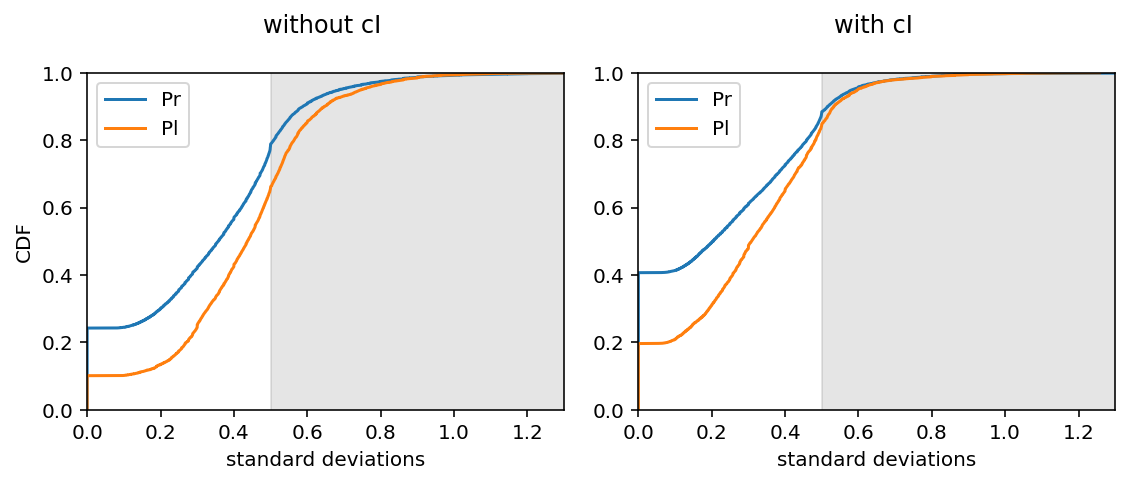

In [55]:
fig, axs = plt.subplots(1,2,figsize=(8,3.5))

for act in [0,1]:
    ax = axs.flat[act]
    for j,dataID in enumerate(dataset):
        x = seqStats[dataID][act]["Std"].values
        y = 1+np.arange(len(x))
        y = y/y.max()
        ax.plot(sorted(x),y, label=dataID)
    axlbl = 'without '[:-act*3-1]+" cI"
#     plt.text(1,0,"%s \n"%axlbl, ha="right", va="bottom", transform = ax.transAxes)
    ax.fill_betweenx([-1,2], [stdThreshold]*2,[5]*2, color="grey", alpha = .2)
    ax.set_title("%s \n"%axlbl)
    ax.set_xlabel("standard deviations")
    ax.set_xlim(0,1.3)
    ax.set_ylim(0,1)
    ax.legend(loc=2)
axs[0].set_ylabel("CDF")

fig.tight_layout()

In [56]:
for dataID in dataset:
    seqDF[dataID]["keep_for_0"] = False
    seqDF[dataID]["keep_for_1"] = False
    for act in [0,1]:
        axlbl = 'without '[:-act*3-1]+" cI"
        df = seqStats[dataID][act]
        print ("%s | %10s : %5i -> %5i"%(dataID, axlbl, len(df), len(df.query("Std<=%f"%stdThreshold))))
        idxToKeep = seqStats[dataID][act].query("Std<=%f"%stdThreshold).index
        seqStats[dataID][act] = seqStats[dataID][act].loc[idxToKeep]
        seqDF[dataID].loc[idxToKeep,"keep_for_%i"%act] = True

Pr | without cI : 29020 -> 22884
Pr |    with cI : 29020 -> 25662
Pl | without cI :  6415 ->  4239
Pl |    with cI :  6415 ->  5436


In [57]:
df = pd.DataFrame({dataID: seqDF[dataID].iloc[:,-2:].sum() for dataID in dataset})
df.loc["keep_both"] = {dataID:seqDF[dataID].iloc[:,-2:].all(axis=1).sum() for dataID in dataset}
df

,Pr,Pl
keep_for_0,22884,4239
keep_for_1,25662,5436
keep_both,20696,3673


### mean, median and mode should not be too different

In [58]:
for dataID in dataset:
    for act in [0,1]:
        axlbl = 'without '[:-act*3-1]+" cI"
        df = seqStats[dataID][act]
        fltr = np.all([
                df.Mean.round()==df.Mode,
                np.abs(df.Median-df.Mode)<.5,
            ], axis=0)
        print ("%s | %10s : %5i -> %5i"%(dataID, axlbl, len(df), fltr.sum()))
        seqStats[dataID][act] = df[fltr]
        seqDF[dataID].loc[df.index[~fltr], "keep_for_%i"%act] = False

Pr | without cI : 22884 -> 22769
Pr |    with cI : 25662 -> 25599
Pl | without cI :  4239 ->  4222
Pl |    with cI :  5436 ->  5417


In [59]:
df = pd.DataFrame({dataID: seqDF[dataID].iloc[:,-2:].sum() for dataID in dataset})
df.loc["keep_both"] = {dataID:seqDF[dataID].iloc[:,-2:].all(axis=1).sum() for dataID in dataset}
df

,Pr,Pl
keep_for_0,22769,4222
keep_for_1,25599,5417
keep_both,20535,3641


## result

<ipython-input-60-a787596a5c72>:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(levels, [])
<ipython-input-60-a787596a5c72>:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(levels, [])


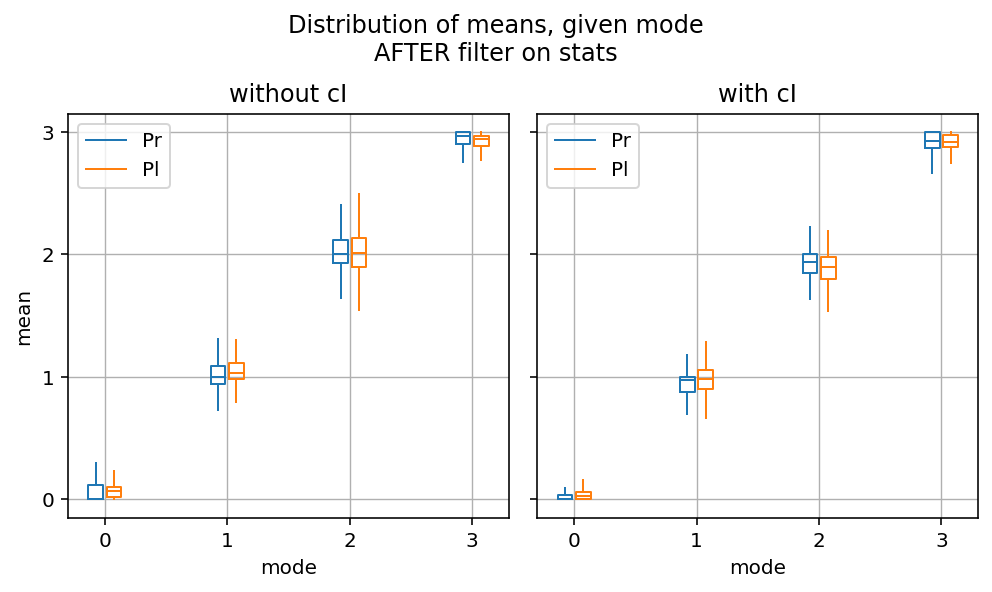

In [60]:
fig, axs = plt.subplots(1,2,figsize=(7,4), sharex=True, sharey=True)
fig.suptitle("Distribution of means, given mode\nAFTER filter on stats\n")
for act in [0,1]:
    ax = axs.flat[act]
    ax.grid(lw = .7)
    bx = {}
    for j,dataID in enumerate(dataset):
        df = seqStats[dataID][act]
        levels = sorted(df.Mean.round().astype(int).unique())
        bx[dataID] = ax.boxplot([df.query("Mode==%i"%i)["Mean"] for i in levels],
                    positions=np.arange(4)+.15*(j-.5),
                    boxprops = {"color":"C%i"%j},
                    whiskerprops = {"color":"C%i"%j},
#                     flierprops = {"marker":".",'markerfacecolor':"C%i"%j, "mew":0,"markersize":3},
                    showfliers = False,
                    medianprops = {"color":"C%i"%j},
                    showcaps = False,
                    widths = .12);
    ax.set_xticks(levels, [])
    ax.set_title('without '[:-act*3-1]+" cI")
    ax.set_xlim(-.3,3.3)
    ax.legend([bx[dataID]["boxes"][0] for dataID in bx.keys()],
               bx.keys(), loc=2)
    
    ax.set_xlabel("mode")
    ax.set_xticks(levels)
    ax.set_xticklabels(levels)
    ax.set_aspect("equal")
ax.set_yticks(levels)
ax.set_yticklabels(levels)
axs[0].set_ylabel("mean")
fig.tight_layout(rect=(0,0,1,.9))

# How does the distribution of number of mutations look now?

In [61]:
# only for the case without cI
act = 0

In [62]:
tally(map(type,seqDF[dataID].Sequence))

[(str, 6415)]

In [63]:
# redefine SA:
SA = {dataID: np.array([
    list(row.Sequence) for ix,row in seqDF[dataID].iterrows() \
        if row["keep_for_%i"%act]                          # exclude those that I just filtered out 
            and row["Shine-Dalgarno pos"]==consensusAnchor # to avoid indels as much as possible
            and len(row.Sequence)==Lpeak                   # still constrain on sequences that had the same length
    ]) for dataID in dataset}

Text(0, 0.5, 'mutation rate, $\\mu$')

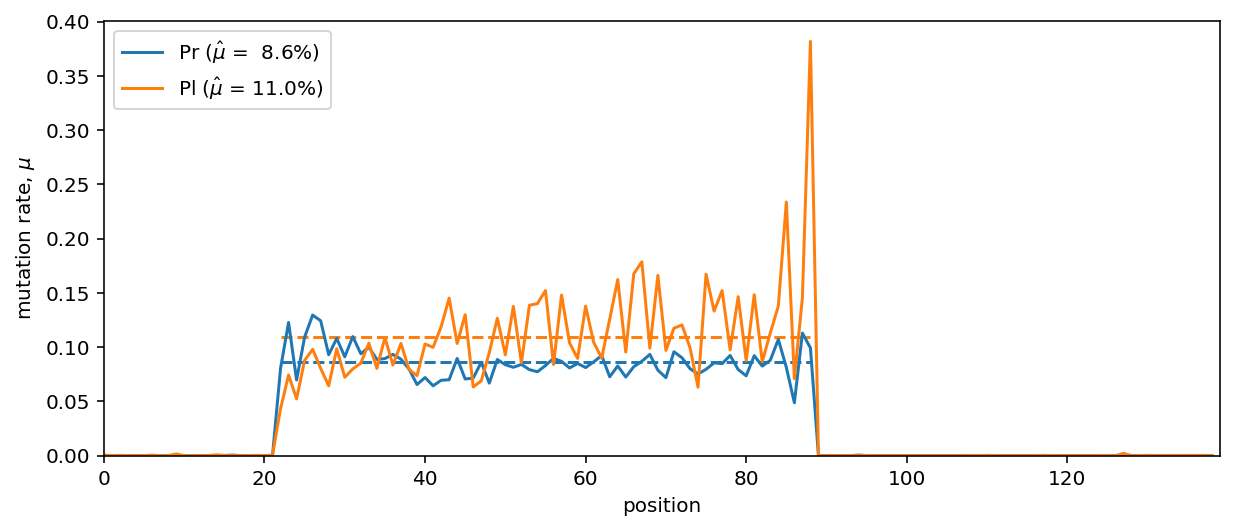

In [64]:
plt.figure(figsize=(10,4))
for dataID in dataset:
    noMutantsPerPos[dataID] = np.array([np.sum(v!=mode(v)) for v in SA[dataID].T])
    mutRatePerPos  [dataID] = noMutantsPerPos[dataID]*1./len(SA[dataID])
    i0, ie = np.where(mutRatePerPos[dataID]>1e-2)[0][[0,-1]]
    avgMutRate = mutRatePerPos[dataID][i0:ie].mean()
    c = plt.plot([])[0].get_color()
    #     plt.bar(range(len(mutRatePerPos[dataID])),mutRatePerPos[dataID],color=c,
    #              label=r"%s ($\hat\mu$ = %4.1f%%)"%(dataID,avgMutRate*100),
    #            alpha = .3)
    plt.plot(mutRatePerPos[dataID],c=c,
             label=r"%s ($\hat\mu$ = %4.1f%%)"%(dataID,avgMutRate*100))
    plt.hlines([avgMutRate],[i0],[ie],color=c, linestyle="--")
    
plt.legend(loc=2)
plt.xlim(0,Lpeak)
plt.ylim(0,)
# plt.title("mutation rate per position")
plt.xlabel("position")
plt.ylabel(r"mutation rate, $\mu$")

Text(0, 0.5, 'PDF')

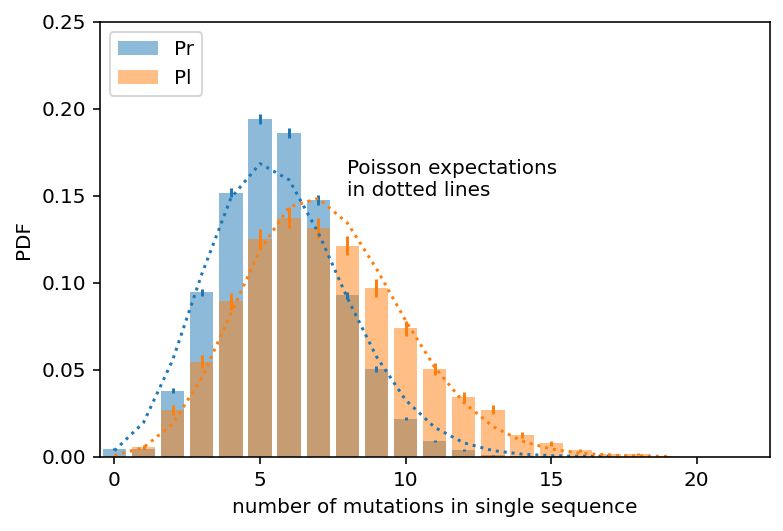

In [65]:
for dataID in dataset:
    x,y = np.array(tally([(s[i0:ie]!=ancArray[dataID]).sum() for s in SA[dataID]])).T
    ye = y**.5/y.sum()
    y = y/y.sum()
#     c = plt.plot(x[x<20],y[x<20], label = dataID, lw=.6)[0].get_color()
    c = plt.plot([])[0].get_color()
    plt.bar(x,y, label = dataID, alpha = .5,color=c)
    plt.errorbar(x,y,ye,color=c,ls="none")
    avgmu = mutRatePerPos[dataID][i0:ie].mean()
    yp = dst.poisson.pmf(x,avgmu*(ie-i0))
    plt.plot(x,yp,c=c,ls="dotted",)
#              label="Poisson with $\hat\mu = %.3f$"%avgmu)
plt.text(8,.15,"Poisson expectations\nin dotted lines")
plt.legend(loc=2)
plt.xlim(-.5,22.5)
plt.ylim(0,.25)
plt.xlabel("number of mutations in single sequence")
plt.ylabel("PDF")

# Saving

In [90]:
for dataID in dataset:
    for act in [0,1]:
        suffix = ["constitutive","with_C1"][act]
        df = seqStats[dataID][act]
        df = df.join(seqDF[dataID])
        df = df[[
            u'AlignedSeq',
            u'Median', u'Mode', u'Mean', u'Std',
            u'Coverage',
        ]].rename({"AlignedSeq":"sequence"}, axis="columns")
        df = df.sort_values("Coverage", ascending=False)
        df.to_csv("%s_%s_all.csv"%(dataID,suffix), index=False)
        df = df.query("Coverage>=30")
        df.to_csv("%s_%s.csv"%(dataID,suffix), index=False)